# Modeling Ames, Iowa Housing Data

Our procedure is

1. Remove a few outliers from training data as defined in documentation
2. Drop features with excessive missing values
3. Add engineered features
4. Make pipeline step for filling missing values according to the meaning of being missing for each feature
5. Make pipeline steps for encoding categorical features
5. Evaluate common machine learning models with training data
6. Combine the best performing models using stacking
7. Generate test data predictions from stacked model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

## Load Data

In [2]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [3]:
# Drop ID column for modelling
train_id = train['Id']
test_id = test['Id']
train = train.drop('Id', axis=1)
test = test.drop('Id', axis=1)

## 1. Outlier Removal

Text(0.5, 1.0, 'After Outlier Removal')

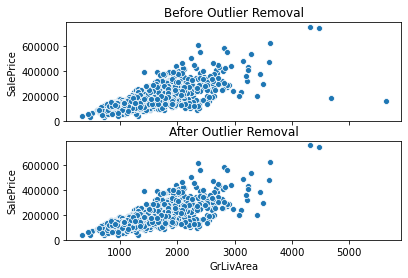

In [4]:
# remove outliers and confirm that they were removed correctly
f, axs = plt.subplots(2, 1, sharex=True, sharey=True)
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train, ax=axs[0])
train = train[(train['GrLivArea'] < 4500) | (train['SalePrice'] > 300000)]
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train, ax=axs[1])
axs[0].set_title('Before Outlier Removal')
axs[1].set_title('After Outlier Removal')

## 2. Drop Features with Excessive Missing Values

In [5]:
# drop features that had >40% missing values
to_drop = ['PoolQC', 'MiscFeature', 'Alley', 'FireplaceQu']
train = train.drop(to_drop, axis=1)
test = test.drop(to_drop, axis=1)

## 3. Feature Engineering

In [6]:
# Define feature engineering

# features to log transform
LOG_FEATURES = ['LotFrontage', 'LotArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'PoolArea']

def engineer_features(data):
    #data['Age'] = data['YrSold']-data['YearBuilt']
    #MSSubClass ordering doesn't seem like its ordering is particularly relevant, sow we will convert it to a categorical feature
    data['MSSubClass'] = data['MSSubClass'].astype(str)
    # We'll also convert year and month sold to strings:
    data['YrSold'] = data['YrSold'].astype(str)
    data['MoSold'] = data['MoSold'].astype(str)
    # data['TotalSF'] = data['TotalBsmtSF']+data['1stFlrSF']+data['2ndFlrSF']
    data['haspool'] = data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    data['has2ndfloor'] = data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    data['hasgarage'] = data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    data['hasbsmt'] = data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    data['hasfireplace'] = data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    for feature in LOG_FEATURES:
        data[feature] = np.log1p(data[feature])
    return data

In [7]:
# Apply feature engineering
train = engineer_features(train)
test = engineer_features(test)

## 4. Define how to Handle Missing Values

In [8]:
# imports for modeling
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, RobustScaler, OrdinalEncoder, StandardScaler
from sklearn.linear_model import Ridge, Lasso, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error, make_scorer
import xgboost
import lightgbm as lgb

In [9]:
# Split training data into features and target
X_train, y_train = train.drop('SalePrice', axis=1), train['SalePrice']

In [10]:
categorical = [i for i in X_train.columns if train.dtypes[i] == 'object']
numerical = [i for i in X_train.columns if train.dtypes[i] != 'object']

In [11]:
# Meaning of missing values from Serigne's notebook (https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard):
#- For these features, NA means or probably means 'None': PoolQC, MiscFeature, Alley, Fence, FirePlaceQu, GarageType, GarageFinish, GarageQual, GarageCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2, MasVnrType, MSSubClass
#- For these features, NA means or probably means 0: GarageArea, GarageCars, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath, MasVnrArea
#- For these features, NA means or probably means 'unknown' or undefined: MSZoning, Utilities, Electrical, KitchenQual, Exterior1st, Exterior2nd, SaleType, GarageYrBuilt
#- For 'Functional', NA means 'Typ'

# define missng values preprocessor:
missing_na = ['Fence', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass']
missing_zero = ['GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']
other_categorical = np.setdiff1d(categorical, missing_na)
other_categorical = np.setdiff1d(other_categorical, ['Functional'])
other_categorical = np.setdiff1d(other_categorical, missing_zero)
other_numerical = np.setdiff1d(numerical, missing_na)
other_numerical = np.setdiff1d(other_numerical, ['Functional'])
other_numerical = np.setdiff1d(other_numerical, missing_zero)
missing_preprocessor = ColumnTransformer([
    ('NA', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='NA'), missing_na),
    ('Functional', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Typ'), ['Functional']),
    ('zero', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0), missing_zero),
    ('unknown_categorical', SimpleImputer(missing_values=np.nan, strategy='most_frequent'), other_categorical),
    ('unknown_numerical', SimpleImputer(missing_values=np.nan, strategy='median'), other_numerical)
])

# names of columns output by missing value preprocessor:
missing_columns_output = np.hstack([missing_na, ['Functional'], missing_zero, other_categorical, other_numerical])

## 5. Define how to Encode Categorical Features

In [12]:
# Make encoding preprocessor
def col_indicies(names):
    """Return boolean array that is true when column name is in names"""
    return np.isin(missing_columns_output, names)

ordinal = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond']
non_ordinal_categorical = np.setdiff1d(categorical, ordinal)
housing_encoder = ColumnTransformer([
    ('quality', OrdinalEncoder(categories=[['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']]*len(ordinal)), col_indicies(ordinal)),
    ('LandSlope', OrdinalEncoder(categories=[['Gtl', 'Mod', 'Sev']]), col_indicies(['LandSlope'])),
    ('BsmtExposure', OrdinalEncoder(categories=[['NA', 'No', 'Mn', 'Av', 'Gd']]), col_indicies(['BsmtExposure'])),
    ('Functional', OrdinalEncoder(categories=[['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']]), col_indicies(['Functional'])),
    ('GarageFinish', OrdinalEncoder(categories=[['NA', 'Unf', 'RFn', 'Fin']]), col_indicies(['GarageFinish'])),
    ('Fence', OrdinalEncoder(categories=[['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']]), col_indicies(['Fence'])),
    ('BsmtFinType', OrdinalEncoder(categories=[['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']]*2), col_indicies(['BsmtFinType1', 'BsmtFinType2'])),
    ('PavedDrive', OrdinalEncoder(categories=[['N', 'P', 'Y']]), col_indicies(['PavedDrive'])),
    ('categorical', OneHotEncoder(handle_unknown='ignore'), col_indicies(non_ordinal_categorical))
], remainder='passthrough')

housing_all_hot_encoder = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown='ignore'), col_indicies(categorical))
], remainder='passthrough')

## 6. Evaluate Common Machine Learning Models

In [13]:
# Ridge
ridge = Pipeline([
    ('fill_missing', missing_preprocessor),
    ('encoding', housing_encoder),
    ('scale', RobustScaler(with_centering=False)),
    ('ridge', Ridge(alpha=11.905772393787833))
])
ridge = TransformedTargetRegressor(ridge, func=np.log1p, inverse_func=np.expm1)


hot_ridge = Pipeline([
    ('fill_missing', missing_preprocessor),
    ('encoding', housing_all_hot_encoder),
    ('scale', RobustScaler(with_centering=False)),
    ('ridge', Ridge(alpha=11.905772393787833))
])
hot_ridge = TransformedTargetRegressor(hot_ridge, func=np.log1p, inverse_func=np.expm1)


In [14]:
# ridge hyperparameter tuning
"""
alphas = np.logspace(0.5, 2, 30)
param_grid = {
    'regressor__ridge__alpha': alphas
}
tuned_ridge = GridSearchCV(ridge, param_grid, n_jobs=-1, cv=3, verbose=10, scoring='neg_mean_squared_log_error')
tuned_ridge.fit(X_train, y_train)
plt.figure()
plt.semilogx(alphas, tuned_ridge.cv_results_['mean_test_score'])
print(tuned_ridge.best_params_)
# best alpha: 11.905772393787833
"""

"\nalphas = np.logspace(0.5, 2, 30)\nparam_grid = {\n    'regressor__ridge__alpha': alphas\n}\ntuned_ridge = GridSearchCV(ridge, param_grid, n_jobs=-1, cv=3, verbose=10, scoring='neg_mean_squared_log_error')\ntuned_ridge.fit(X_train, y_train)\nplt.figure()\nplt.semilogx(alphas, tuned_ridge.cv_results_['mean_test_score'])\nprint(tuned_ridge.best_params_)\n# best alpha: 11.905772393787833\n"

In [15]:
# Lasso
lasso = Pipeline([
    ('fill_missing', missing_preprocessor),
    ('encoding', housing_encoder),
    ('scale', RobustScaler(with_centering=False)),
    ('lasso', Lasso(alpha=0.000565620644760902))
])
lasso = TransformedTargetRegressor(lasso, func=np.log1p, inverse_func=np.expm1)

hot_lasso = Pipeline([
    ('fill_missing', missing_preprocessor),
    ('encoding', housing_all_hot_encoder),
    #('scale', StandardScaler(with_mean=False)),
    ('scale', RobustScaler(with_centering=False)),
    ('lasso', Lasso(alpha=0.000565620644760902))
])
hot_lasso = TransformedTargetRegressor(hot_lasso, func=np.log1p, inverse_func=np.expm1)

In [16]:
# lasso hyperparameter tuning
"""
alphas = np.logspace(-3.5, -2.5, 100)
param_grid = {
    'regressor__lasso__alpha': alphas
}
tuned_lasso = GridSearchCV(lasso, param_grid, n_jobs=-1, cv=3, verbose=10, scoring='neg_mean_squared_log_error')
tuned_lasso.fit(X_train, y_train)
plt.figure()
plt.semilogx(alphas, tuned_lasso.cv_results_['mean_test_score'])
print(tuned_lasso.best_params_)
# best alpha: 0.000565620644760902
"""

"\nalphas = np.logspace(-3.5, -2.5, 100)\nparam_grid = {\n    'regressor__lasso__alpha': alphas\n}\ntuned_lasso = GridSearchCV(lasso, param_grid, n_jobs=-1, cv=3, verbose=10, scoring='neg_mean_squared_log_error')\ntuned_lasso.fit(X_train, y_train)\nplt.figure()\nplt.semilogx(alphas, tuned_lasso.cv_results_['mean_test_score'])\nprint(tuned_lasso.best_params_)\n# best alpha: 0.000565620644760902\n"

In [17]:
# Kernel Ridge Regression
kernel_ridge = Pipeline([
    ('fill_missing', missing_preprocessor),
    ('encoding', housing_encoder),
    ('scale', RobustScaler(with_centering=False)),
    ('kridge', KernelRidge(kernel='poly', degree=2, alpha=48.93900918477494))
])
kernel_ridge = TransformedTargetRegressor(kernel_ridge, func=np.log1p, inverse_func=np.expm1)

In [18]:
# kernel ridge hyperparameter tuning
"""
alphas = np.logspace(0.5, 2, 30)
param_grid = {
    'regressor__kridge__alpha': alphas
}
tuned_kernel_ridge = GridSearchCV(kernel_ridge, param_grid, n_jobs=-1, cv=3, verbose=10, scoring='neg_mean_squared_log_error')
tuned_kernel_ridge.fit(X_train, y_train)
plt.figure()
plt.semilogx(alphas, tuned_kernel_ridge.cv_results_['mean_test_score'])
print(tuned_kernel_ridge.best_params_)
print(tuned_kernel_ridge.best_score_)
# best alpha: 48.93900918477494
"""

"\nalphas = np.logspace(0.5, 2, 30)\nparam_grid = {\n    'regressor__kridge__alpha': alphas\n}\ntuned_kernel_ridge = GridSearchCV(kernel_ridge, param_grid, n_jobs=-1, cv=3, verbose=10, scoring='neg_mean_squared_log_error')\ntuned_kernel_ridge.fit(X_train, y_train)\nplt.figure()\nplt.semilogx(alphas, tuned_kernel_ridge.cv_results_['mean_test_score'])\nprint(tuned_kernel_ridge.best_params_)\nprint(tuned_kernel_ridge.best_score_)\n# best alpha: 48.93900918477494\n"

In [19]:
# k-Nearest Neighbors
knn = Pipeline([
    ('fill_missing', missing_preprocessor),
    ('encoding', housing_encoder),
    ('scale', RobustScaler(with_centering=False)),
    ('knn', KNeighborsRegressor(n_neighbors=9, weights='distance', p=1))
])
knn = TransformedTargetRegressor(knn, func=np.log1p, inverse_func=np.expm1)


In [20]:
# knn hyperparameter tuning
"""
n_neighbors = [4, 5, 6, 7, 8, 9, 10, 12, 16]
param_grid = {
    'regressor__knn__n_neighbors': n_neighbors
}
tuned_knn = GridSearchCV(knn, param_grid, n_jobs=-1, cv=3, verbose=10, scoring='neg_mean_squared_log_error')
tuned_knn.fit(X_train, y_train)
plt.figure()
plt.semilogx(n_neighbors, tuned_knn.cv_results_['mean_test_score'])
print(tuned_knn.best_params_)
# best n_neighbors: 6
"""

"\nn_neighbors = [4, 5, 6, 7, 8, 9, 10, 12, 16]\nparam_grid = {\n    'regressor__knn__n_neighbors': n_neighbors\n}\ntuned_knn = GridSearchCV(knn, param_grid, n_jobs=-1, cv=3, verbose=10, scoring='neg_mean_squared_log_error')\ntuned_knn.fit(X_train, y_train)\nplt.figure()\nplt.semilogx(n_neighbors, tuned_knn.cv_results_['mean_test_score'])\nprint(tuned_knn.best_params_)\n# best n_neighbors: 6\n"

In [21]:
# Random Forest
rf = Pipeline([
    ('fill_missing', missing_preprocessor),
    ('encoding', housing_encoder),
    ('scale', RobustScaler(with_centering=False)),
    ('rf', RandomForestRegressor(n_jobs=-1))
])
rf = TransformedTargetRegressor(rf, func=np.log1p, inverse_func=np.expm1)
#_ = rf.fit(X_train, y_train)

In [22]:
# Random Forest hyperparameter tuning
param_grid = {
    'regressor__rf__max_depth': [10, 20, 30, 40, 50, 60, None],
    'regressor__rf__max_features': ['auto', 'sqrt'],
    'regressor__rf__min_samples_leaf': [1, 2, 4],
    'regressor__rf__n_estimators': [200, 400, 600, 800, 1000, 1200]
}
tuned_rf = RandomizedSearchCV(rf, param_grid, n_jobs=-1, cv=3, n_iter=10)
#tuned_rf.fit(X_train, y_train)

In [23]:
# xgboost
param_init = {
    "max_depth": 5, # default: 3 only for depthwise
    "n_estimators": 3000, # default: 500
    "learning_rate": 0.01, # default: 0.05
    "subsample": 0.5,
    "colsample_bytree": 0.7,  # default:  1.0
    "min_child_weight": 1.5,
    "reg_alpha": 0.75,
    "reg_lambda": 0.4,
    "seed": 42,
#     "eval_metric": "rmse"
}
param_fit = {
    "xgb__eval_metric": "rmse",
    #"xgb__early_stopping_rounds": 500, # default: 100
    "xgb__verbose": 200
    #"xgb__eval_set": [(X_val, y_val)]
}
xgb_model = Pipeline([
    ('fill_missing', missing_preprocessor),
    ('encoding', housing_encoder),
    ('scale', RobustScaler(with_centering=False)),
    ('xgb', xgboost.XGBRegressor(**param_init))
])
xgb_model = TransformedTargetRegressor(xgb_model, func=np.log1p, inverse_func=np.expm1)

In [24]:
# lgbm
param_init = {
    'objective': 'regression',
    'num_leaves': 5,
    'learning_rate': 0.05,
    'n_estimators': 720,
    'max_bin': 55,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'feature_fraction': 0.2319,
    'feature_fraction_seed': 9,
    'bagging_seed': 9,
    'min_data_in_leaf': 6,
    'min_sum_hessian_in_leaf': 11
}
lgbm_model = Pipeline([
    ('fill_missing', missing_preprocessor),
    ('encoding', housing_encoder),
    ('scale', RobustScaler(with_centering=False)),
    ('lgbm', lgb.LGBMRegressor(**param_init))
])
lgbm_model = TransformedTargetRegressor(lgbm_model, func=np.log1p, inverse_func=np.expm1)

In [25]:
# define individual models to assess
models = {
    'ridge': ridge,
    #'hot_ridge': hot_ridge,
    'lasso': lasso,
    #'hot_lasso': hot_lasso,
    'kernel ridge': kernel_ridge,
    'knn': knn,
    'random forest': rf,
    'xgboost': xgb_model,
    'lgbm': lgbm_model
}

In [26]:
# assess models performances
for name, model in models.items():
    print(f'{name}:')
    print(np.sqrt(np.mean(cross_val_score(model, X_train, y_train, cv=4, scoring=make_scorer(mean_squared_log_error), n_jobs=-1))))

ridge:
0.11385073210732304
lasso:
0.11243949278342086
kernel ridge:
0.14545448224375518
knn:
0.20440833319299628
random forest:
0.13726084103747038
xgboost:
0.11455602247851239
lgbm:
0.1168706021907239


## 7. Combine Best Performing Individual Models with Stacking

In [27]:
# Make stacked model using better performing models
estimators = [('lasso', lasso),
              ('ridge', ridge),
              ('xgb', xgb_model),
              ('lgbm', lgbm_model)]
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
print(np.sqrt(np.mean(cross_val_score(stacking_regressor, X_train, y_train, cv=3, scoring=make_scorer(mean_squared_log_error), n_jobs=-1))))

0.1162057815406539


In [28]:
# Refit best model on all training+validation data
best_model = stacking_regressor    # although the stacked model didn't have as high of CV as lasso, it did do better on the test data
_ = best_model.fit(train.drop('SalePrice', axis=1), train['SalePrice'])

## 8. Generate Test Set Predictions

In [29]:
# make submission test file
sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = best_model.predict(test)
sub.to_csv('submission.csv', index=False)